In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures  
from sklearn.metrics import r2_score
import os

In [2]:
data_path = r"D:\pythonai\house_data"

In [3]:
locations = ['dachang', 'yanjiao', 'majuqiao', 'yizhuang']

In [164]:
plt.rcParams["font.family"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False  

In [4]:
print(f"The data will be read from the following path: {data_path}")
print(f"The area to be processed {locations}")

The data will be read from the following path: D:\pythonai\house_data
The area to be processed ['dachang', 'yanjiao', 'majuqiao', 'yizhuang']


In [5]:
sample_file = os.path.join(data_path, f"{locations[0]}_sell.csv")
sample_df = pd.read_csv(sample_file)
print("Sample format of housing sales data:")
display(sample_df.head())

sample_rent_file = os.path.join(data_path, f"{locations[0]}_rent.csv")
sample_rent_df = pd.read_csv(sample_rent_file)
print("\nSample format for rental data:")
display(sample_rent_df.head())

Sample format of housing sales data:


,area_sqm,unit_price_yuan_per_sqm
0,70.00,8785
1,119.00,5126
2,85.60,5957
3,118.00,7330
4,75.82,6594



Sample format for rental data:


,area_sqm,rent_yuan_per_month
0,250,6200
1,73,600
2,79,1400
3,78,700
4,92,500


In [165]:
def load_and_preprocess_data():
    all_data = []
    
    for location in locations:
        sell_file = os.path.join(data_path, f"{location}_sell.csv")
        sell_df = pd.read_csv(sell_file)
        sell_df['location'] = location
        sell_df['type'] = 'sell'
        
        rent_file = os.path.join(data_path, f"{location}_rent.csv")
        rent_df = pd.read_csv(rent_file)
        rent_df['location'] = location
        rent_df['type'] = 'rent'
        
        rent_df['rent_per_sqm'] = rent_df['rent_yuan_per_month'] / rent_df['area_sqm']    # Calculate the rent per square meter
        
        all_data.append(sell_df)
        all_data.append(rent_df)
        print(f"The sales and rental data of {location} have been loaded")
    
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.rename(columns={'unit_price_yuan_per_sqm': 'price_per_sqm'}, inplace=True)    # Rename the price column in the housing sales data to maintain consistency
    
    return combined_df

combined_data = load_and_preprocess_data()

print("\nBasic information of the merged dataset:")
print(f"Dataset shape: {combined_data.shape}")
display(combined_data.head())
display(combined_data.tail())

print("\nData type and missing value situation:")
display(combined_data.info())

# Data deduplication: Remove records where both the area and the price are the same
sell_data_dup = combined_data[combined_data['type'] == 'sell'].copy()
sell_data_dup = sell_data_dup.drop_duplicates(subset=['area_sqm', 'price_per_sqm'])
rent_data_dup = combined_data[combined_data['type'] == 'rent'].copy()
rent_data_dup = rent_data_dup.drop_duplicates(subset=['area_sqm', 'rent_per_sqm'])

combined_data_dup = pd.concat([sell_data_dup, rent_data_dup], ignore_index=True)
print("\nBasic information of the de-duplicated dataset:")
print(f"Shape of the de-duplicated dataset:{combined_data_dup.shape}")



The sales and rental data of dachang have been loaded
The sales and rental data of yanjiao have been loaded
The sales and rental data of majuqiao have been loaded
The sales and rental data of yizhuang have been loaded

Basic information of the merged dataset:
Dataset shape: (8043, 6)


,area_sqm,price_per_sqm,location,type,rent_yuan_per_month,rent_per_sqm
0,70.00,8785.0,dachang,sell,NaN,NaN
1,119.00,5126.0,dachang,sell,NaN,NaN
2,85.60,5957.0,dachang,sell,NaN,NaN
3,118.00,7330.0,dachang,sell,NaN,NaN
4,75.82,6594.0,dachang,sell,NaN,NaN


,area_sqm,price_per_sqm,location,type,rent_yuan_per_month,rent_per_sqm
8038,90.0,NaN,yizhuang,rent,4300.0,47.777778
8039,13.0,NaN,yizhuang,rent,1500.0,115.384615
8040,102.0,NaN,yizhuang,rent,7000.0,68.627451
8041,75.0,NaN,yizhuang,rent,4500.0,60.000000
8042,101.0,NaN,yizhuang,rent,5000.0,49.504950



Data type and missing value situation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8043 entries, 0 to 8042
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   area_sqm             8043 non-null   float64
 1   price_per_sqm        3694 non-null   float64
 2   location             8043 non-null   object 
 3   type                 8043 non-null   object 
 4   rent_yuan_per_month  4349 non-null   float64
 5   rent_per_sqm         4349 non-null   float64
dtypes: float64(4), object(2)
memory usage: 377.1+ KB


None


Basic information of the de-duplicated dataset:
Shape of the de-duplicated dataset:(4364, 6)


In [166]:
#The upper part restrains the absence of missing values, and the lower part analyzes and handles outliers
def analyze_outliers(df, column, location=None):
    if location:
        data = df[(df['location'] == location)][column].dropna()
    else:
        data = df[column].dropna()
    
    # Detect outliers using the IQR method
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return len(outliers), lower_bound, upper_bound, data
def remove_outliers(df, column):
    """Remove the outliers in the specified column"""
    cleaned_df = pd.DataFrame()
    
    for location in df['location'].unique():
        loc_df = df[df['location'] == location].copy()
        data = loc_df[column].dropna()
        
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        loc_clean = loc_df[(loc_df[column] >= lower_bound) & (loc_df[column] <= upper_bound)]
        cleaned_df = pd.concat([cleaned_df, loc_clean], ignore_index=True)
        
        print(f"{location}: The original sample size {len(loc_df)}, the sample size after cleaning {len(loc_clean)},Remove the outliers {len(loc_df) - len(loc_clean)}")
    
    return cleaned_df 
# Outlier processing is carried out based on the de-duplicated data
sell_data_dup = combined_data_dup[combined_data_dup['type'] == 'sell'].copy()
rent_data_dup = combined_data_dup[combined_data_dup['type'] == 'rent'].copy()

print("Handling of abnormal values in housing sales data:")
sell_clean = remove_outliers(sell_data_dup, 'price_per_sqm')

print("\nHandling of outliers in rental data:")
rent_clean = remove_outliers(rent_data_dup, 'rent_per_sqm')

Handling of abnormal values in housing sales data:
dachang: The original sample size 70, the sample size after cleaning 69,Remove the outliers 1
yanjiao: The original sample size 819, the sample size after cleaning 769,Remove the outliers 50
majuqiao: The original sample size 798, the sample size after cleaning 790,Remove the outliers 8
yizhuang: The original sample size 704, the sample size after cleaning 693,Remove the outliers 11

Handling of outliers in rental data:
dachang: The original sample size 627, the sample size after cleaning 600,Remove the outliers 27
yanjiao: The original sample size 609, the sample size after cleaning 567,Remove the outliers 42
majuqiao: The original sample size 427, the sample size after cleaning 390,Remove the outliers 37
yizhuang: The original sample size 310, the sample size after cleaning 288,Remove the outliers 22


In [167]:
price_rent_ratio = {}

print("Calculation of the ratio of house prices to rents in each region:")
for location in locations:
    # Obtain the median house price per square meter in this area
    avg_price = sell_clean[sell_clean['location'] == location]['price_per_sqm'].median()
    
    # Obtain the median rent per square meter (monthly) for this area
    avg_rent = rent_clean[rent_clean['location'] == location]['rent_per_sqm'].median()
    
    # Calculate the ratio of house prices to rents 
    if avg_rent > 0:  
        ratio = avg_price / (avg_rent )  
        price_rent_ratio[location] = ratio
        print(f"{location} Median house price-to-rent ratio: {ratio:.2f}")

Calculation of the ratio of house prices to rents in each region:
dachang Median house price-to-rent ratio: 449.76
yanjiao Median house price-to-rent ratio: 439.53
majuqiao Median house price-to-rent ratio: 574.96
yizhuang Median house price-to-rent ratio: 821.63


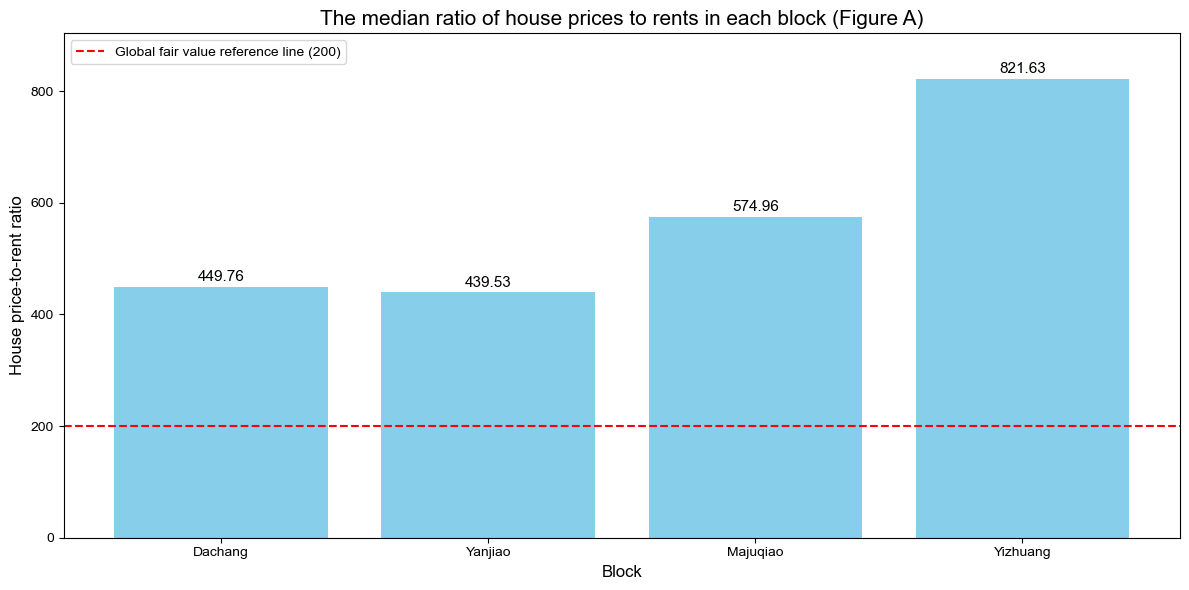

In [168]:
plt.figure(figsize=(12, 6))
locations_display = [loc.capitalize() for loc in price_rent_ratio.keys()]
ratios = list(price_rent_ratio.values())

bars = plt.bar(locations_display, ratios, color='skyblue')

plt.axhline(y=200, color='r', linestyle='--', label='Global fair value reference line (200)')

plt.title('The median ratio of house prices to rents in each block (Figure A)', fontsize=15)
plt.xlabel('Block', fontsize=12)
plt.ylabel('House price-to-rent ratio', fontsize=12)
plt.ylim(0, max(ratios) * 1.1)  
plt.legend()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.2f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('figure_a.png', dpi=300)
plt.show()

In [170]:
sell_model_data = sell_clean.copy()
rent_model_data = rent_clean.copy()

# Create a virtual variable for the location
sell_dummies = pd.get_dummies(sell_model_data['location'], prefix='loc', drop_first=False)
rent_dummies = pd.get_dummies(rent_model_data['location'], prefix='loc', drop_first=False)

sell_model_data = pd.concat([sell_model_data, sell_dummies], axis=1)
rent_model_data = pd.concat([rent_model_data, rent_dummies], axis=1)

# Define the basic model features (original area + position dummy variable)
base_features = ['area_sqm'] + list(sell_dummies.columns)
print(f"Features used in the basic model: {base_features}")

# Model 1: Predict the housing price per square meter
X_sell = sell_model_data[base_features]
y_sell = sell_model_data['price_per_sqm']

model1 = LinearRegression()
model1.fit(X_sell, y_sell)
sell_predictions = model1.predict(X_sell)
r2_model1 = r2_score(y_sell, sell_predictions)
print(f"Model 1 (House Price Prediction) R² value:{r2_model1:.4f}")

# Model 2: Predict rent per square meter
X_rent = rent_model_data[base_features]
y_rent = rent_model_data['rent_per_sqm']

model2 = LinearRegression()
model2.fit(X_rent, y_rent)
rent_predictions = model2.predict(X_rent)
r2_model2 = r2_score(y_rent, rent_predictions)
print(f"Model 2 (Rent Forecast) R² value:{r2_model2:.4f}")


Features used in the basic model: ['area_sqm', 'loc_dachang', 'loc_majuqiao', 'loc_yanjiao', 'loc_yizhuang']
Model 1 (House Price Prediction) R² value:0.8212
Model 2 (Rent Forecast) R² value:0.8401


In [171]:
# Generate predictive data
all_locations = pd.DataFrame({
    'location': np.repeat(locations, 200),    # Generate 200 sample points for each area
    'area_sqm': np.tile(np.linspace(50, 200, 200), len(locations))    # The area range is 50 to 200 square meters
})

# Create virtual variables
all_dummies = pd.get_dummies(all_locations['location'], prefix='loc', drop_first=False)
all_model_data = pd.concat([all_locations, all_dummies], axis=1)

# Make sure all the features exist
for feature in base_features:
    if feature not in all_model_data.columns:
        all_model_data[feature] = 0

# Predict prices and rents
all_model_data['predicted_price'] = model1.predict(all_model_data[base_features])
all_model_data['predicted_rent'] = model2.predict(all_model_data[base_features])

# Calculate the ratio of house prices to rents
all_model_data['price_rent_ratio'] = all_model_data['predicted_price'] / (all_model_data['predicted_rent'] )

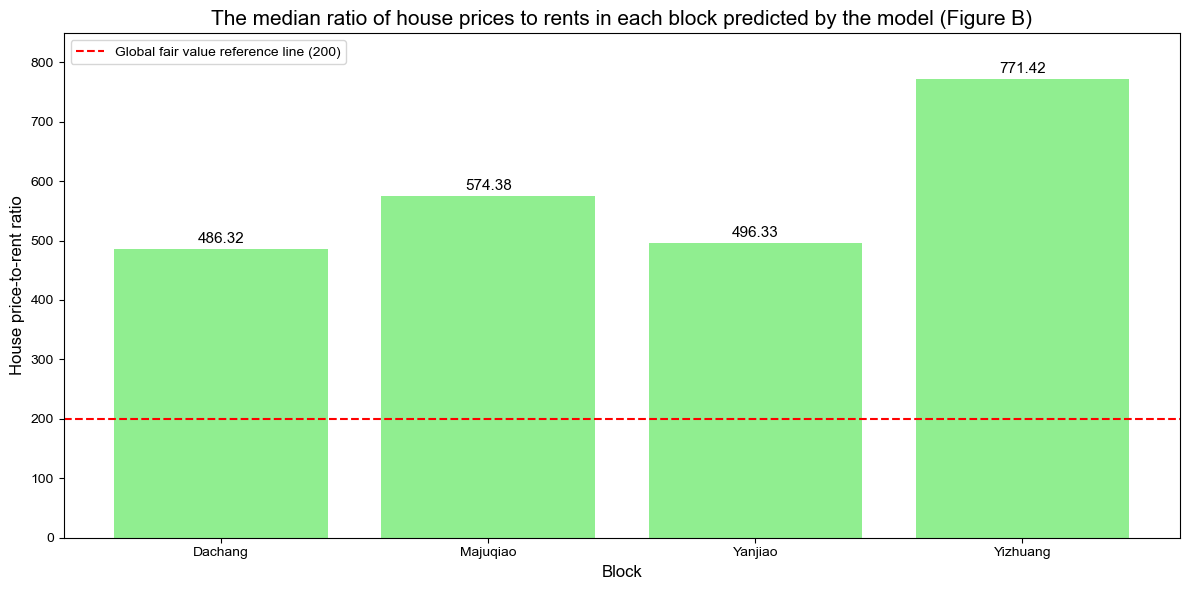

In [172]:
plt.figure(figsize=(12, 6))
ratio_by_location = all_model_data.groupby('location')['price_rent_ratio'].median().to_dict()
locations_display = [loc.capitalize() for loc in ratio_by_location.keys()]
ratios = list(ratio_by_location.values())

bars = plt.bar(locations_display, ratios, color='lightgreen')

plt.axhline(y=200, color='r', linestyle='--', label='Global fair value reference line (200)')

plt.title('The median ratio of house prices to rents in each block predicted by the model (Figure B)', fontsize=15)
plt.xlabel('Block', fontsize=12)
plt.ylabel('House price-to-rent ratio', fontsize=12)
plt.ylim(0, max(ratios) * 1.1)
plt.legend()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.2f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('figure_b.png', dpi=300)
plt.show()

In [173]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features (area squared term)
poly = PolynomialFeatures(degree=2, include_bias=False)
sell_poly = poly.fit_transform(sell_clean[['area_sqm']])  
rent_poly = poly.fit_transform(rent_clean[['area_sqm']])

sell_dummies_ext = pd.get_dummies(sell_clean['location'], prefix='loc', drop_first=False)
rent_dummies_ext = pd.get_dummies(rent_clean['location'], prefix='loc', drop_first=False)

# Merge polynomial features with dummy variables
sell_X_plus = pd.concat([
    pd.DataFrame(sell_poly[:, :2], columns=['area_sqm', 'area_sqm_sq']),    # Reserve the area and square items
    sell_dummies_ext
], axis=1)

rent_X_plus = pd.concat([
    pd.DataFrame(rent_poly[:, :2], columns=['area_sqm', 'area_sqm_sq']),
    rent_dummies_ext
], axis=1)

# Add interaction items 
common_locations = set(sell_dummies_ext.columns) & set(rent_dummies_ext.columns)  
for col in common_locations:
    sell_X_plus[f'area_sq_{col}'] = sell_X_plus['area_sqm_sq'] * sell_X_plus[col]
    rent_X_plus[f'area_sq_{col}'] = rent_X_plus['area_sqm_sq'] * rent_X_plus[col]

extended_features = list(set(sell_X_plus.columns) | set(rent_X_plus.columns))
extended_features.sort()  
print(f"Features used in the extended model: {extended_features}")

for feature in extended_features:
    if feature not in sell_X_plus.columns:
        sell_X_plus[feature] = 0
    if feature not in rent_X_plus.columns:
        rent_X_plus[feature] = 0
sell_X_plus = sell_X_plus[extended_features]
rent_X_plus = rent_X_plus[extended_features]
# Model 1+:
y_sell_ext = sell_clean['price_per_sqm']
model1_plus = LinearRegression(fit_intercept=True)
model1_plus.fit(sell_X_plus, y_sell_ext)
r2_model1_plus = r2_score(y_sell_ext, model1_plus.predict(sell_X_plus))
print(f"Model 1+ R²: {r2_model1_plus:.4f}")
print(f"improvement compared to the basic model:{r2_model1_plus - r2_model1:.4f}")

# Model 2+:
y_rent_ext = rent_clean['rent_per_sqm']
model2_plus = LinearRegression(fit_intercept=True)
model2_plus.fit(rent_X_plus, y_rent_ext)
r2_model2_plus = r2_score(y_rent_ext, model2_plus.predict(rent_X_plus))
print(f"Model 2+ R²值: {r2_model2_plus:.4f}")
print(f"improvement compared to the basic model: {r2_model2_plus - r2_model2:.4f}")
    


Features used in the extended model: ['area_sq_loc_dachang', 'area_sq_loc_majuqiao', 'area_sq_loc_yanjiao', 'area_sq_loc_yizhuang', 'area_sqm', 'area_sqm_sq', 'loc_dachang', 'loc_majuqiao', 'loc_yanjiao', 'loc_yizhuang']
Model 1+ R²: 0.8244
improvement compared to the basic model:0.0033
Model 2+ R²值: 0.8466
improvement compared to the basic model: 0.0066


In [174]:
def add_extended_features(df, location_dummies, extended_features):
    df_new = df.copy().reset_index(drop=True)
    location_dummies = location_dummies.copy().reset_index(drop=True)
    
    df_new['area_sqm_sq'] = df_new['area_sqm'] **2
   
    existing_dummies = [col for col in location_dummies.columns if col in df_new.columns]
    if existing_dummies:
        df_new = df_new.drop(columns=existing_dummies)
    df_new = pd.concat([df_new, location_dummies], axis=1).reset_index(drop=True)
  
    for col in location_dummies.columns:
        inter_col = f'area_sq_{col}'
        if inter_col in extended_features:
            df_new[inter_col] = df_new['area_sqm_sq'] * df_new[col]
  
    return df_new[extended_features].fillna(0)  

all_locations_ext = pd.DataFrame({
    'location': np.repeat(locations, 200),
    'area_sqm': np.tile(np.linspace(35, 250, 200), len(locations))
}).reset_index(drop=True)

all_dummies_ext = pd.get_dummies(all_locations_ext['location'], prefix='loc', drop_first=False)
all_dummies_ext = all_dummies_ext.reset_index(drop=True)

X_pred = add_extended_features(all_locations_ext, all_dummies_ext, extended_features)

all_extended['predicted_price'] = model1_plus.predict(X_pred)
all_extended['predicted_rent'] = model2_plus.predict(X_pred)

all_results = all_locations_ext.copy() 
all_results['predicted_price'] = model1_plus.predict(X_pred)  
all_results['predicted_rent'] = model2_plus.predict(X_pred)    
all_results['price_rent_ratio'] = all_results['predicted_price'] / (all_results['predicted_rent'] )  





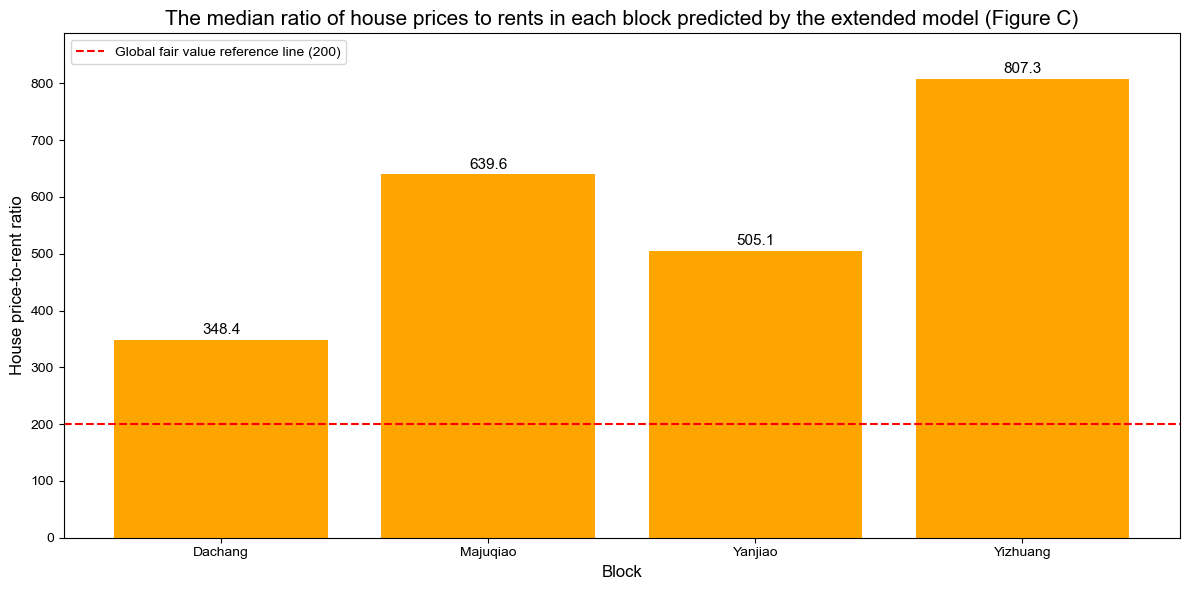

In [175]:
plt.figure(figsize=(12, 6))
ratio_by_location_plus = all_results.groupby('location')['price_rent_ratio'].median().to_dict()
locations_display = [loc.capitalize() for loc in ratio_by_location_plus.keys()]
ratios = list(ratio_by_location_plus.values())

bars = plt.bar(locations_display, ratios, color='orange')

plt.axhline(y=200, color='r', linestyle='--', label='Global fair value reference line (200)')

plt.title('The median ratio of house prices to rents in each block predicted by the extended model (Figure C)', fontsize=15)
plt.xlabel('Block', fontsize=12)
plt.ylabel('House price-to-rent ratio', fontsize=12)
plt.ylim(0, max(ratios) * 1.1)
plt.legend()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.1f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('figure_c.png', dpi=300)
plt.show()

In [176]:
original_ratios = price_rent_ratio
model_ratios = ratio_by_location
extended_model_ratios = ratio_by_location_plus

comparison = pd.DataFrame({
    'Block': [loc.capitalize() for loc in locations],
    'Original data': [original_ratios.get(loc, np.nan) for loc in locations],
    'Basic model prediction': [model_ratios.get(loc, np.nan) for loc in locations],
    'Extended model prediction': [extended_model_ratios.get(loc, np.nan) for loc in locations]
})

print("Comparison of house price to rent ratios obtained by three methods:")
display(comparison.round(2))

Comparison of house price to rent ratios obtained by three methods:


,Block,Original data,Basic model prediction,Extended model prediction
0,Dachang,449.76,486.32,348.40
1,Yanjiao,439.53,496.33,505.14
2,Majuqiao,574.96,574.38,639.59
3,Yizhuang,821.63,771.42,807.31


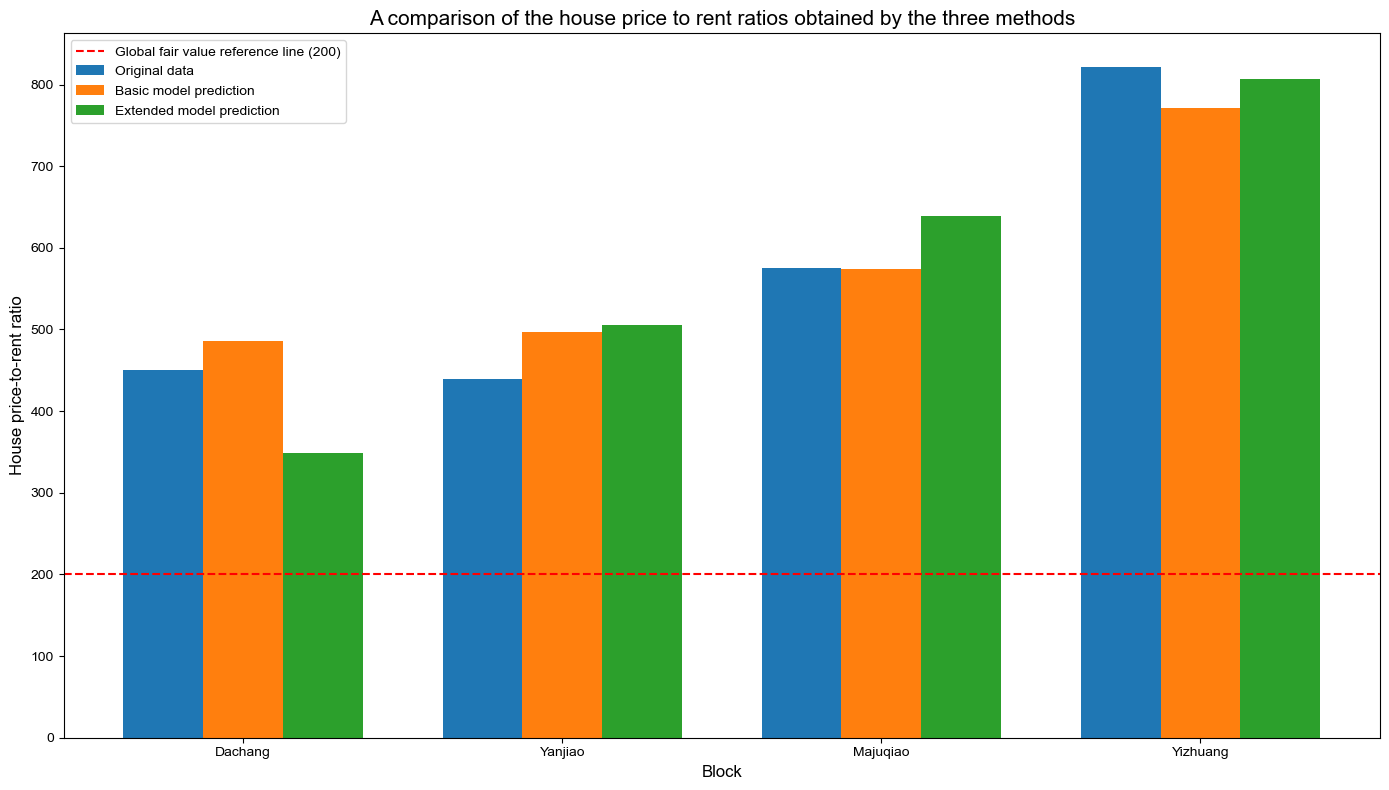

In [177]:
plt.figure(figsize=(14, 8))

x = np.arange(len(locations))  
width = 0.25  

plt.bar(x - width, [original_ratios.get(loc, 0) for loc in locations], width, label='Original data')
plt.bar(x, [model_ratios.get(loc, 0) for loc in locations], width, label='Basic model prediction')
plt.bar(x + width, [extended_model_ratios.get(loc, 0) for loc in locations], width, label='Extended model prediction')

plt.axhline(y=200, color='r', linestyle='--', label='Global fair value reference line (200)')

plt.title('A comparison of the house price to rent ratios obtained by the three methods', fontsize=15)
plt.xlabel('Block', fontsize=12)
plt.ylabel('House price-to-rent ratio', fontsize=12)
plt.xticks(x, [loc.capitalize() for loc in locations])
plt.legend()

plt.tight_layout()
plt.savefig('comparison.png', dpi=300)
plt.show()

In [179]:
print("Analysis conclusion:")
print("1. Compared with the R² value, the performance of the extended model is" +(" Better than "if r2_model1_plus > r2_model1 and r2_model2_plus > r2_model2 else" worse than ") +"Basic Model.")
print("2. Among all districts, " + 
      (f"{[k for k, v in original_ratios.items() if v == max(original_ratios.values())][0]} has the highest price-to-rent ratio." 
       if original_ratios else ""))
print("3. Compared with the global fair value reference line (200)，" + 
      (f"{sum(1 for v in original_ratios.values() if v > 200)} blocks are above the reference line." 
       if original_ratios else ""))    

Analysis conclusion:
1. Compared with the R² value, the performance of the extended model is Better than Basic Model.
2. Among all districts, yizhuang has the highest price-to-rent ratio.
3. Compared with the global fair value reference line (200)，4 blocks are above the reference line.


In [185]:
print("1. Yizhuang is located in Tongzhou, the sub - center of Beijing. It has a cluster of industries, plenty of employment opportunities, a large inflow of population, strong demand for buying houses, and high added value of real estate.")

print("2. These four blocks are all concentrated around Beijing. The real estate market in these areas is affected by factors such as 'metropolitan area radiation' and 'investment speculation', which further pushes up housing prices. However, rent growth is relatively slow due to the limitations of residents' actual income and the maturity of the rental market. In the end, the house price-to-rent ratio is much higher than the global reference line.")

print("3. For the real data, the median of house prices and the median of rents are taken respectively and compared. While for the prediction model, a set of prediction data is set, a set of house prices and rents are predicted respectively, a set of ratios is obtained by comparing them, and the median of this set of ratios is taken as the final result. The difference between the two methods and other factors lead to the situation that the two models cannot be clearly distinguished in terms of advantages and disadvantages in the comparison chart. However, from the perspective of R², the extended model considers more comprehensively and is also a better prediction model.")


1. Yizhuang is located in Tongzhou, the sub - center of Beijing. It has a cluster of industries, plenty of employment opportunities, a large inflow of population, strong demand for buying houses, and high added value of real estate.
2. These four blocks are all concentrated around Beijing. The real estate market in these areas is affected by factors such as 'metropolitan area radiation' and 'investment speculation', which further pushes up housing prices. However, rent growth is relatively slow due to the limitations of residents' actual income and the maturity of the rental market. In the end, the house price-to-rent ratio is much higher than the global reference line.
3. For the real data, the median of house prices and the median of rents are taken respectively and compared. While for the prediction model, a set of prediction data is set, a set of house prices and rents are predicted respectively, a set of ratios is obtained by comparing them, and the median of this set of ratios is